![UBA](assets/UBA_header_black.png)

In [138]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator
import requests
import zipfile
import folium

# Ingesta de los datos

In [66]:
USUARIOS_FILE_URL = r"https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/bicicletas-publicas/badata_ecobici_usuarios_2024.csv"
RECORRIDOS_FILE_URL = r"https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/bicicletas-publicas/badata_ecobici_recorridos_realizados_2024.zip"
USUARIOS_CSV = pathlib.Path("./datasets/badata_ecobici_usuarios_2024.csv")
RECORRIDOS_ZIP = pathlib.Path("./datasets/badata_ecobici_recorridos_realizados_2024.zip")
RECORRIDOS_CSV = pathlib.Path("./datasets/badata_ecobici_recorridos_realizados_2024.csv")

In [67]:
# Descarga de los archivos
GET_FILES = False

if GET_FILES:
    def download_file(url, dest_path):
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(dest_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)


    download_file(USUARIOS_FILE_URL, USUARIOS_CSV)
    download_file(RECORRIDOS_FILE_URL, RECORRIDOS_ZIP)

    with zipfile.ZipFile(RECORRIDOS_ZIP) as zip_ref:
        zip_contents = zip_ref.namelist()
        if zip_contents:
            zip_ref.extract(zip_contents[0], path=RECORRIDOS_CSV.parent)
            extracted_file = RECORRIDOS_CSV.parent / zip_contents[0]
            extracted_file.rename(RECORRIDOS_CSV)

    RECORRIDOS_ZIP.unlink()

In [136]:
users_df = pd.read_csv(USUARIOS_CSV)
rides_df = pd.read_csv(RECORRIDOS_CSV)

# Dataset seleccionado: BA Ecobici
Contiene información sobre los viajes realizados a través del servicio público de bicicletas BA Ecobici, que opera en la Ciudad Autónoma de Buenos Aires.

### Dataset de usuarios (CSV)
Contiene el listado de usuarios del servicio, que se dieron de alta en 2024.

In [69]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197079 entries, 0 to 197078
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id_usuario      197079 non-null  int64 
 1   genero_usuario  197079 non-null  object
 2   edad_usuario    197079 non-null  int64 
 3   fecha_alta      197079 non-null  object
 4   hora_alta       197079 non-null  object
dtypes: int64(2), object(3)
memory usage: 7.5+ MB


In [70]:
users_df.head()

,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta
0,1083579,OTHER,23,2024-01-01,01:59:02
1,1083608,OTHER,36,2024-01-01,02:55:46
2,1083612,OTHER,38,2024-01-01,03:13:15
3,1083616,FEMALE,21,2024-01-01,03:40:54
4,1083631,MALE,36,2024-01-01,05:02:35


In [71]:
users_df.describe()

,id_usuario,edad_usuario
count,1.970790e+05,197079.000000
mean,1.182078e+06,30.764521
std,5.689283e+04,18.896208
min,1.083538e+06,4.000000
25%,1.132808e+06,21.000000
50%,1.182078e+06,27.000000
75%,1.231348e+06,37.000000
max,1.280619e+06,2021.000000


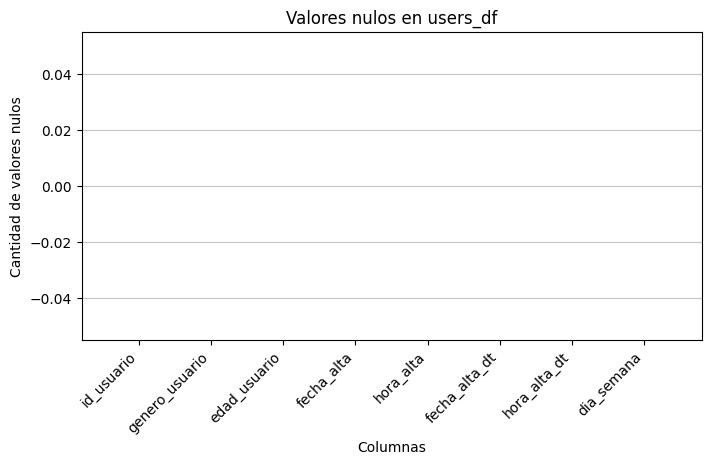

In [116]:
# Exploración de valores nulos
plt.figure(figsize=(8, 4))
plt.grid(axis='y', alpha=0.75)
plt.bar(users_df.columns, users_df.isnull().sum(), align='center', zorder=2)
plt.xticks(rotation=45, ha='right')
plt.title('Valores nulos en users_df')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de valores nulos')
plt.show()

In [73]:
# Usuarios duplicados
duplicated_users = users_df[users_df.duplicated(subset='id_usuario', keep=False)]
print(f"Cantidad de usuarios duplicados: {duplicated_users['id_usuario'].nunique()}")
duplicated_users.sort_values(by='id_usuario').head(10)

Cantidad de usuarios duplicados: 0


,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta


##### Exploración de generos

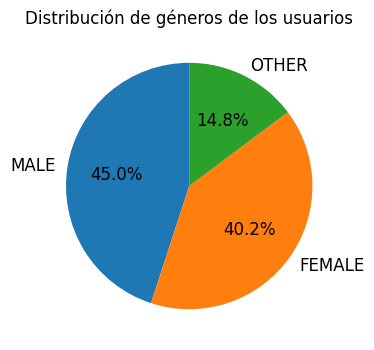

In [117]:
# Pie chart de los géneros de usuarios
plt.figure(figsize=(4, 4))
users_df['genero_usuario'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, fontsize=12)
plt.title('Distribución de géneros de los usuarios')
plt.ylabel('')
plt.show()

In [75]:
# Conteo de usuarios por género
gender_counts = users_df['genero_usuario'].value_counts()
print(gender_counts)

genero_usuario
MALE      88656
FEMALE    79310
OTHER     29113
Name: count, dtype: int64


##### Exploración de edades

<Axes: xlabel='edad_usuario'>

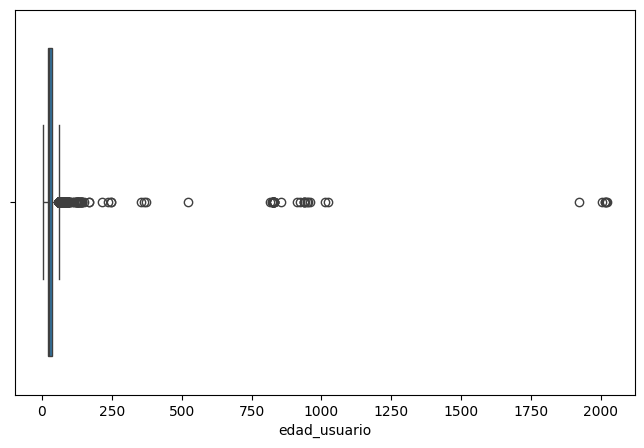

In [76]:
# Boxplot de edades
plt.figure(figsize=(8, 5))
sns.boxplot(x=users_df['edad_usuario'])

In [77]:
# Media moda mediana de edades
mean = users_df['edad_usuario'].mean().round(2)
median = users_df['edad_usuario'].median().round(2)
mode = users_df['edad_usuario'].mode()[0].round(2)

print("Media:", mean)
print("Mediana:", median)
print("Moda:", mode)

Media: 30.76
Mediana: 27.0
Moda: 18


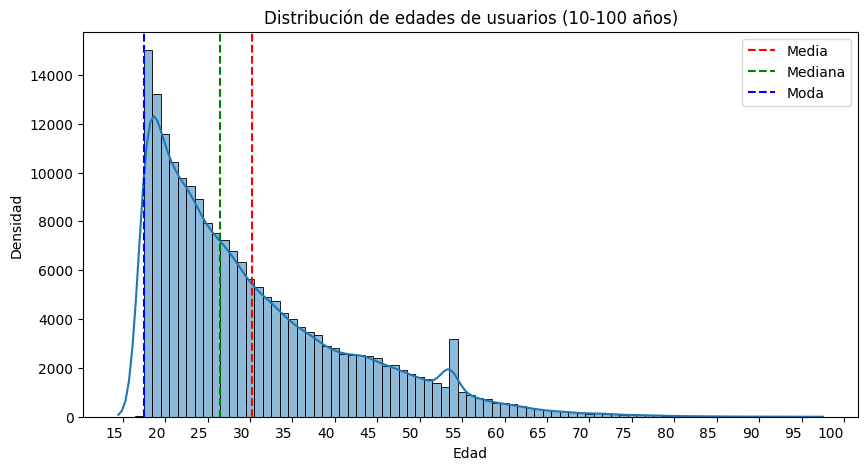

In [78]:
# Histograma de edades
mask_edad = (users_df['edad_usuario'] >= 10) & (users_df['edad_usuario'] <= 100)
plt.figure(figsize=(10, 5))
ax = sns.histplot(users_df[mask_edad]['edad_usuario'], kde=True, binwidth=1)
ticks = [t + 0.5 for t in range(10, 101, 5)]  # Esto es para centrar los bines en los ticks
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.set_xticklabels([str(int(tick)) for tick in ticks], ha='right')
plt.title('Distribución de edades de usuarios (10-100 años)')
plt.xlabel('Edad')
plt.ylabel('Densidad')

# Media, moda y mediana
ax.axvline(mean, color='r', linestyle='--', label='Media')
ax.axvline(median, color='g', linestyle='--', label='Mediana')
ax.axvline(mode, color='b', linestyle='--', label='Moda')
ax.legend()

plt.show()


Text(0, 0.5, 'Densidad')

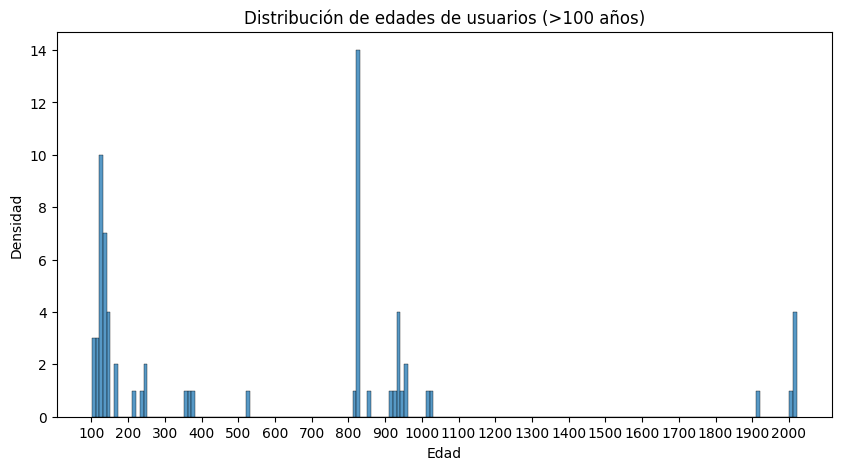

In [79]:
# Histograma de edades de mas de 100 años
mask_edad = users_df["edad_usuario"] > 100
plt.figure(figsize=(10, 5))
sns.histplot(users_df[mask_edad]['edad_usuario'], binwidth=10)
plt.title('Distribución de edades de usuarios (>100 años)')
plt.xticks(range(100, users_df['edad_usuario'].max() + 1, 100))
plt.xlabel('Edad')
plt.ylabel('Densidad')

In [80]:
# 10 usuarios mas 'viejos'
users_df.sort_values(by='edad_usuario', ascending=False).head(10)

,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta
56690,1109473,MALE,2021,2024-02-11,20:24:45
104417,1238144,MALE,2019,2024-10-27,20:08:47
124365,1130915,FEMALE,2016,2024-03-21,21:19:50
184254,1202670,MALE,2016,2024-09-07,18:39:34
66885,1189702,FEMALE,2004,2024-08-09,22:34:35
10936,1150325,FEMALE,1921,2024-04-29,13:33:57
137312,1277262,OTHER,1022,2024-12-27,13:11:42
62421,1167228,MALE,1012,2024-06-16,15:20:11
18616,1199423,OTHER,960,2024-09-02,17:37:56
92904,1279416,OTHER,952,2024-12-30,09:20:27


##### Exploración de fecha y hora de alta

In [104]:
# Parseo de columnas de fecha y hora
users_df['fecha_alta_dt'] = pd.to_datetime(users_df['fecha_alta'], errors='coerce')
users_df['hora_alta_dt'] = pd.to_datetime(users_df['hora_alta'], format='%H:%M:%S', errors='coerce').dt.time
users_df['dia_semana'] = users_df['fecha_alta_dt'].dt.day_name()

In [86]:
# 10 fechas de alta mas repetidas
users_df['fecha_alta_dt'].value_counts().head(10)

fecha_alta_dt
2024-11-09    1720
2024-05-09    1315
2024-10-11    1278
2024-09-29    1197
2024-10-27    1154
2024-11-10    1128
2024-11-18    1119
2024-09-08    1076
2024-01-24    1062
2024-09-15    1041
Name: count, dtype: int64

In [103]:
# 10 horas de alta mas repetidas
users_df['hora_alta_dt'].apply(lambda x: x.hour).value_counts().head(10)

hora_alta_dt
16    18531
15    17762
17    17386
14    15614
18    14997
13    14042
12    13425
11    11756
19    11261
10     8984
Name: count, dtype: int64

In [106]:
# Altas por dia de la semana
users_df['dia_semana'].value_counts()

dia_semana
Sunday       31073
Saturday     28801
Monday       28599
Thursday     27978
Friday       27115
Tuesday      26841
Wednesday    26672
Name: count, dtype: int64

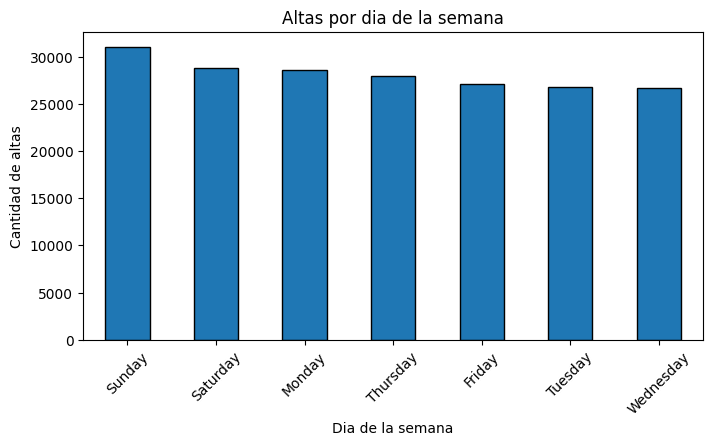

In [115]:
# Bar chart de altas por dia de la semana
plt.figure(figsize=(8, 4))
users_df['dia_semana'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Altas por dia de la semana')
plt.xlabel('Dia de la semana')
plt.ylabel('Cantidad de altas')
plt.xticks(rotation=45)
plt.show()

### Dataset de recorridos (CSV)
Contiene información de los viajes realizados.

In [ ]:
rides_df.info()
# duracion_recorrido está en segundos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560404 entries, 0 to 3560403
Data columns (total 18 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   id_recorrido                int64         
 1   duracion_recorrido          int64         
 2   fecha_origen_recorrido      datetime64[ns]
 3   id_estacion_origen          int64         
 4   nombre_estacion_origen      object        
 5   direccion_estacion_origen   object        
 6   long_estacion_origen        float64       
 7   lat_estacion_origen         float64       
 8   fecha_destino_recorrido     object        
 9   id_estacion_destino         int64         
 10  nombre_estacion_destino     object        
 11  direccion_estacion_destino  object        
 12  long_estacion_destino       float64       
 13  lat_estacion_destino        float64       
 14  id_usuario                  float64       
 15  modelo_bicicleta            object        
 16  genero            

In [18]:
rides_df.head()

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
0,24496816,17,2024-12-31 08:18:58,202,001 - FACULTAD DE DERECHO,Av. Pres. Figueroa Alcorta 2120,-58.390602,-34.583749,2024-12-31 08:19:15,202,001 - FACULTAD DE DERECHO,Av. Pres. Figueroa Alcorta 2120,-58.390602,-34.583749,1166678.0,FIT,FEMALE
1,24492524,2,2024-12-30 19:21:45,251,388 - Plaza Jose C Paz,Dr. Prof. Pedro Chutro 2881,-58.402483,-34.641728,2024-12-30 19:21:47,41,041 - PARQUE PATRICIOS II,Av Caseros 3015,-58.405888,-34.637123,1133415.0,FIT,FEMALE
2,24493951,0,2024-12-30 21:08:03,418,345 - Plaza Mafalda,Conde & Concepción Arenal,-58.444580,-34.580938,NaN,418,345 - Plaza Mafalda,Conde & Concepción Arenal,-58.444580,-34.580938,1158360.0,ICONIC,FEMALE
3,24494848,6575,2024-12-30 23:22:17,177,177 -PLANETARIO,Av. Belisario Roldán y Av. Sarmiento,-58.411598,-34.571079,2024-12-31 01:11:52,336,207 - PLAZA ARENALES,Nueva York 3949,-58.511146,-34.599731,1224331.0,FIT,FEMALE
4,24495039,3162,2024-12-30 23:52:00,359,250 - Fleni,2292 Montañeses,-58.450479,-34.555602,2024-12-31 00:44:42,85,085 - AGUERO,"Aguero & Mansilla, Lucio Norberto, General",-58.409178,-34.594806,1280053.0,ICONIC,FEMALE


In [35]:
rides_df.describe()

,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,long_estacion_origen,lat_estacion_origen,id_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,mes
count,3.560404e+06,3.560404e+06,3560404,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06,3.560404e+06
mean,2.234132e+07,1.274680e+03,2024-07-09 05:40:23.004178688,2.355957e+02,-5.842302e+01,-3.459877e+01,2.371506e+02,-5.842318e+01,-3.459896e+01,7.908728e+05,6.748984e+00
min,2.018097e+07,0.000000e+00,2024-01-01 00:06:50,2.000000e+00,-5.852710e+01,-3.468777e+01,2.000000e+00,-5.852710e+01,-3.468777e+01,2.400000e+01,1.000000e+00
25%,2.123866e+07,4.930000e+02,2024-04-02 09:37:25.249999872,9.300000e+01,-5.844965e+01,-3.461635e+01,9.600000e+01,-5.844966e+01,-3.461649e+01,5.118240e+05,4.000000e+00
50%,2.235131e+07,8.810000e+02,2024-07-15 18:12:45.500000,1.990000e+02,-5.842095e+01,-3.460028e+01,2.000000e+02,-5.842095e+01,-3.460075e+01,9.131670e+05,7.000000e+00
75%,2.343700e+07,1.473000e+03,2024-10-15 12:50:11.249999872,3.780000e+02,-5.839374e+01,-3.458255e+01,3.790000e+02,-5.839374e+01,-3.458234e+01,1.113537e+06,1.000000e+01
max,2.450328e+07,2.571165e+06,2024-12-31 23:58:25,5.770000e+02,-5.835547e+01,-3.453669e+01,5.770000e+02,-5.835547e+01,-3.453669e+01,1.280599e+06,1.200000e+01
std,1.257073e+06,9.582717e+03,NaN,1.657999e+02,3.830469e-02,2.441487e-02,1.657100e+02,3.848631e-02,2.477407e-02,3.881981e+05,3.553999e+00


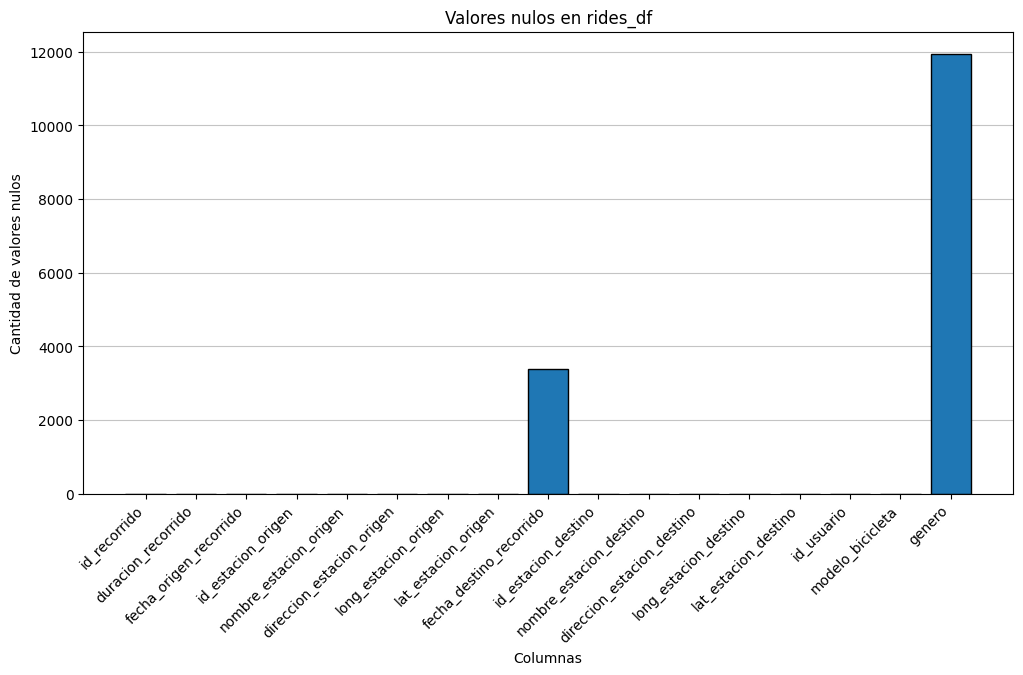

In [19]:
# Exploración de valores nulos
plt.figure(figsize=(12, 6))
plt.grid(axis='y', alpha=0.75)
plt.bar(rides_df.columns, rides_df.isnull().sum(), align='center', zorder=2, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('Valores nulos en rides_df')
plt.xlabel('Columnas')
plt.ylabel('Cantidad de valores nulos')
plt.show()

##### Exploración de duraciones de recorrido

In [145]:
# Recorrido mas largo en días
print(f"Recorrido más largo: {round(rides_df['duracion_recorrido'].max()/3600/24, 2)} días")

Recorrido más largo: 29.76 días


In [27]:
# El usuario que más tiempo usó las bicicletas
user_durations = rides_df.groupby('id_usuario')['duracion_recorrido'].sum()
max_user_id = user_durations.idxmax()
max_user_duration = user_durations.max()

print(f"Usuario más activo: {max_user_duration/3600:.2f} hs")

Usuario más activo: 738.33 hs


##### Exploración de fecha origen de recorrido

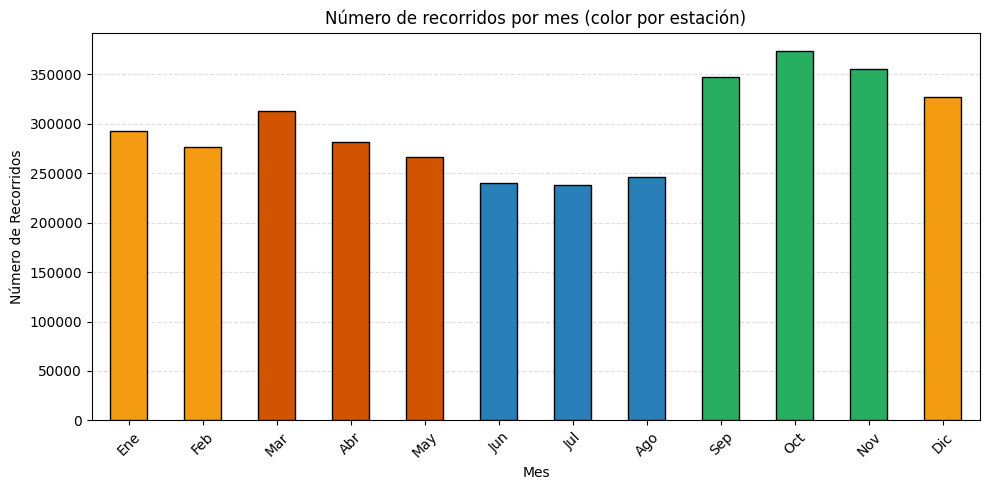

In [ ]:
rides_df['fecha_origen_recorrido'] = pd.to_datetime(rides_df['fecha_origen_recorrido'])
rides_df['mes'] = rides_df['fecha_origen_recorrido'].dt.month

counts = rides_df['mes'].value_counts().reindex(range(1,13), fill_value=0).sort_index()

# Verano: Dic-Ene-Feb; Otoño: Mar-Abr-May; Invierno: Jun-Jul-Ago; Primavera: Sep-Oct-Nov
season_of = {12:'verano', 1:'verano', 2:'verano',
             3:'otoño', 4:'otoño', 5:'otoño',
             6:'invierno', 7:'invierno', 8:'invierno',
             9:'primavera', 10:'primavera', 11:'primavera'}
palette = {'verano':'#F39C12', 'otoño':'#D35400', 'invierno':'#2980B9', 'primavera':'#27AE60'}
colors = [palette[season_of[m]] for m in counts.index]

fig, ax = plt.subplots(figsize=(10, 5))
counts.plot(kind='bar', ax=ax, color=colors, edgecolor='black', zorder=3)

ax.grid(axis='y', linestyle='--', alpha=0.4, zorder=0)
ax.set_axisbelow(True)

ax.set_title('Número de recorridos por mes (color por estación)')
ax.set_xlabel('Mes'); ax.set_ylabel('Número de Recorridos')
ax.set_xticks(range(12))
ax.set_xticklabels(['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'], rotation=45)

plt.tight_layout()
plt.show()


In [163]:
# Dia de la semana con más recorridos
rides_df['dia_semana_origen_recorrido'] = rides_df['fecha_origen_recorrido'].dt.day_name()
print(f"Día de la semana con más recorridos: {rides_df['dia_semana_origen_recorrido'].value_counts().idxmax()} con {rides_df['dia_semana_origen_recorrido'].value_counts().max()} recorridos")

Día de la semana con más recorridos: Thursday con 641452 recorridos


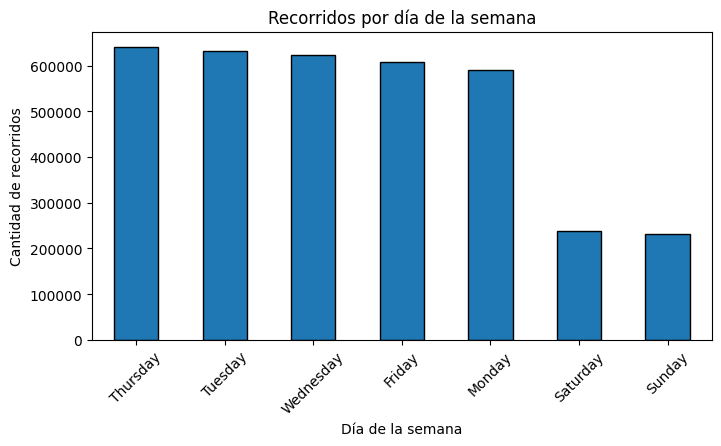

In [164]:
# Bar chart de recorridos por dia de la semana
plt.figure(figsize=(8, 4))
rides_df['dia_semana_origen_recorrido'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Recorridos por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de recorridos')
plt.xticks(rotation=45)
plt.show()

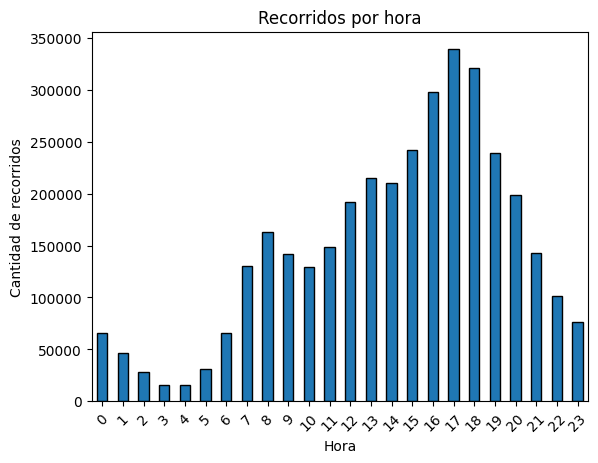

In [171]:
# Recorridos por hora
rides_df['hora_origen_recorrido'] = pd.to_datetime(rides_df['fecha_origen_recorrido'], format='%H:%M:%S', errors='coerce').dt.hour
rides_df['hora_origen_recorrido'].value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Recorridos por hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de recorridos')
plt.xticks(rotation=45)
plt.show()

##### Exploración de géneros (en recorridos, algunos no tienen género asociado)

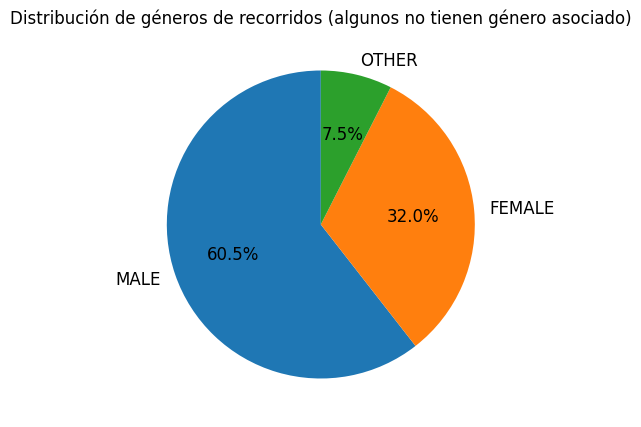

In [125]:
# Pie chart de generos de los recorridos (algunos recorridos no tienen género asociado)
plt.figure(figsize=(5, 5))
rides_df['genero'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, fontsize=12)
plt.title('Distribución de géneros de recorridos (algunos no tienen género asociado)')
plt.ylabel('')
plt.show()

##### Exploración de estaciones

In [40]:
# Estaciones más usadas para iniciar recorridos
origin_top_stations = rides_df['nombre_estacion_origen'].value_counts().sort_values(ascending=False).head(5)
print(origin_top_stations)

nombre_estacion_origen
147 - Constitución             38284
014 - Pacifico                 37594
368 - PLAZA DE LA SHOÁ         37201
005 - Plaza Italia             34547
001 - FACULTAD DE DERECHO      30955
008 - Congreso                 30403
130 - RETIRO II                29311
152 - JULIETA LANTERI          28225
255 - BARRANCAS DE BELGRANO    27729
131- HOSPITAL DE CLÍNICAS      26968
Name: count, dtype: int64


In [ ]:
# Estaciones más usadas para terminar recorridos
destination_top_stations = rides_df['nombre_estacion_destino'].value_counts().sort_values(ascending=False).head(5)
print(destination_top_stations)

nombre_estacion_destino
147 - Constitución             38363
368 - PLAZA DE LA SHOÁ         37425
014 - Pacifico                 37278
005 - Plaza Italia             34607
001 - FACULTAD DE DERECHO      30897
008 - Congreso                 30538
152 - JULIETA LANTERI          29045
130 - RETIRO II                29027
255 - BARRANCAS DE BELGRANO    28051
096 - Carlos Gardel            27076
Name: count, dtype: int64


In [42]:
# Mapa
caba_coords = [-34.6037, -58.3816]
m = folium.Map(location=caba_coords, zoom_start=13, tiles='OpenStreetMap')

# Origenes
cols_ori = ['nombre_estacion_origen', 'lat_estacion_origen', 'long_estacion_origen']
coords = (rides_df[rides_df['nombre_estacion_origen'].isin(origin_top_stations.index)]
          [cols_ori].dropna().drop_duplicates('nombre_estacion_origen'))

for _, r in coords.iterrows():
    nombre, lat, lon = r['nombre_estacion_origen'], float(r['lat_estacion_origen']), float(r['long_estacion_origen'])
    
    folium.Marker([lat, lon], popup=nombre, tooltip=nombre,
                  icon=folium.Icon(color='green', icon='play', prefix='fa')).add_to(m)
    
    folium.Marker([lat, lon],
        icon=folium.DivIcon(
            html=f'<div style="transform:translate(12px,-18px);'
             'background:#fff;border:1px solid rgba(0,0,0,.2);border-radius:4px;'
             'padding:2px 6px;font-size:12px;font-weight:700;color:#000;'
             'display:inline-block;max-width:180px;white-space:nowrap;'
             'overflow:hidden;text-overflow:ellipsis;pointer-events:none;">'
             f'{nombre}</div>'
        )
    ).add_to(m)

m.save('mapa_caba_top_estaciones_orig.html')

In [43]:
# Mapa
caba_coords = [-34.6037, -58.3816]
m = folium.Map(location=caba_coords, zoom_start=13, tiles='OpenStreetMap')

# Destinos
cols_dest = ['nombre_estacion_destino', 'lat_estacion_destino', 'long_estacion_destino']
coords_dest = (rides_df[rides_df['nombre_estacion_destino'].isin(destination_top_stations.index)]
               [cols_dest].dropna().drop_duplicates('nombre_estacion_destino'))

for _, r in coords_dest.iterrows():
    nombre, lat, lon = r['nombre_estacion_destino'], float(r['lat_estacion_destino']), float(r['long_estacion_destino'])
    folium.Marker([lat, lon], popup=nombre, tooltip=nombre,
                  icon=folium.Icon(color='red', icon='flag-checkered', prefix='fa')).add_to(m)
    folium.Marker([lat, lon],
        icon=folium.DivIcon(
            html=f'<div style="transform:translate(12px,-18px);'
             'background:#fff;border:1px solid rgba(0,0,0,.2);border-radius:4px;'
             'padding:2px 6px;font-size:12px;font-weight:700;color:#000;'
             'display:inline-block;max-width:180px;white-space:nowrap;'
             'overflow:hidden;text-overflow:ellipsis;pointer-events:none;">'
             f'{nombre}</div>'
        )
    ).add_to(m)

m.save('mapa_caba_top_estaciones_dest.html')

##### Exploración de usuarios de recorridos

In [141]:
rides_df['id_usuario'] = rides_df['id_usuario'].astype('Int64')

In [144]:
# Usuario que más recorridos hizo
top_user = rides_df['id_usuario'].value_counts().idxmax()
print(f"Usuario que más recorridos hizo: ID {top_user} con {rides_df['id_usuario'].value_counts().max()} recorridos")

Usuario que más recorridos hizo: ID 844251 con 8488 recorridos


### Merge datasets usuarios + recorridos?

In [148]:
# Cuántos usuarios de rides_df están en users_df?
np.isin(rides_df['id_usuario'], users_df['id_usuario']).sum()

np.int64(1136610)

No resulta útil unir ambos datasets, ya que más de un millón de recorridos no tienen `id_usuario` asociado.<br>
Esto se debe a que el dataset de usuarios 2024 solo incluye altas realizadas en ese año, mientras que el dataset de recorridos 2024 también contiene viajes de usuarios que se registraron en años anteriores.